In [1]:
import os
import pandas as pd

In [2]:
folder_path = 'data'

In [3]:
dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df['DATE'] = pd.to_datetime(df['DATE'])
        df.set_index('DATE', inplace=True)
        df.columns = [f"{file_name.replace('.csv', '')}_{col}" for col in df.columns]
        dataframes.append(df)

merged_df = pd.concat(dataframes, axis=1)

merged_df.fillna(method='ffill', inplace=True)

# Remove data older than 1960
merged_df = merged_df[merged_df.index >= '1960-01-01']

merged_df.to_csv('merged_data.csv')

C:\Users\dberw\AppData\Local\Temp\ipykernel_23424\824192782.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [4]:
merged_df = pd.read_csv('merged_data.csv')
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])
merged_df.set_index('DATE', inplace=True)
numeric_df = merged_df.apply(pd.to_numeric, errors='coerce')

In [5]:
growth_df = numeric_df.pct_change()

days_to_predict = 30
numeric_df['GSPC_Close'] = numeric_df['GSPC_Close'].shift(-days_to_predict)

merged_df.fillna(0, inplace=True)

print(growth_df)

            A091RC1Q027SBEA_A091RC1Q027SBEA  A939RX0Q048SBEA_A939RX0Q048SBEA  \
DATE                                                                           
1960-01-01                              NaN                              NaN   
1960-01-04                              0.0                              0.0   
1960-01-05                              0.0                              0.0   
1960-01-06                              0.0                              0.0   
1960-01-07                              0.0                              0.0   
...                                     ...                              ...   
2024-10-01                              0.0                              0.0   
2024-10-02                              0.0                              0.0   
2024-10-03                              0.0                              0.0   
2024-10-04                              0.0                              0.0   
2024-10-07                              

C:\Users\dberw\AppData\Local\Temp\ipykernel_23424\2473897142.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  growth_df = numeric_df.pct_change()


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

X = growth_df.drop(columns=['GSPC_Close']).values
y = growth_df['GSPC_Close'].values

non_nan_indices = ~pd.isna(y)
X = X[non_nan_indices]
y = y[non_nan_indices]

X[np.isinf(X)] = np.nan
X = pd.DataFrame(X).ffill().bfill().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class ComplexFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ComplexFeedForwardNN, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third fully connected layer
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.3)
        
        # Final output layer
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        # First layer
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout1(out)
        
        # Second layer
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout2(out)
        
        # Third layer
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.activation(out)
        out = self.dropout3(out)
        
        # Output layer
        out = self.fc4(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ComplexFeedForwardNN(input_size, hidden_size, output_size).to(device)

X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_test_loss = float('inf')
best_model_state = None
best_epoch = 0

total_epochs = 100_000
increment = 500

train_losses = []
test_losses = []

for epoch_range in range(increment, total_epochs + 1, increment):
    model.train()
    for epoch in range(increment):
        y_pred = model(X_train_tensor)
        
        loss = criterion(y_pred, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)
        test_loss = criterion(y_test_pred, y_test_tensor)
        
        test_losses.append(test_loss.item())

        print(f'Epoch [{epoch_range}], Test Loss: {test_loss.item():.6f}')
        
        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()
            best_model_state = model.state_dict()
            best_epoch = epoch_range
    
    model.train()

model.load_state_dict(best_model_state)
print(f'Best model found at epoch {best_epoch} with Test Loss: {best_test_loss:.6f}')

Using device: cuda
Epoch [500], Test Loss: 0.000094
Epoch [1000], Test Loss: 0.000049
Epoch [1500], Test Loss: 0.000055
Epoch [2000], Test Loss: 0.000048
Epoch [2500], Test Loss: 0.000040
Epoch [3000], Test Loss: 0.000040
Epoch [3500], Test Loss: 0.000034
Epoch [4000], Test Loss: 0.000056
Epoch [4500], Test Loss: 0.000034
Epoch [5000], Test Loss: 0.000030
Epoch [5500], Test Loss: 0.000030
Epoch [6000], Test Loss: 0.000030
Epoch [6500], Test Loss: 0.000045
Epoch [7000], Test Loss: 0.000030
Epoch [7500], Test Loss: 0.000034
Epoch [8000], Test Loss: 0.000122
Epoch [8500], Test Loss: 0.000028
Epoch [9000], Test Loss: 0.000030
Epoch [9500], Test Loss: 0.000031
Epoch [10000], Test Loss: 0.000051
Epoch [10500], Test Loss: 0.000029
Epoch [11000], Test Loss: 0.000053
Epoch [11500], Test Loss: 0.000051
Epoch [12000], Test Loss: 0.000036
Epoch [12500], Test Loss: 0.000030
Epoch [13000], Test Loss: 0.000036
Epoch [13500], Test Loss: 0.000037
Epoch [14000], Test Loss: 0.000058
Epoch [14500], Test L

KeyboardInterrupt: 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assuming growth_df is a DataFrame
X = growth_df.drop(columns=['GSPC_Close']).values
y = growth_df['GSPC_Close'].values

non_nan_indices = ~pd.isna(y)
X = X[non_nan_indices]
y = y[non_nan_indices]

X[np.isinf(X)] = np.nan
X = pd.DataFrame(X).ffill().bfill().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the sequence length for the LSTM
sequence_length = 1000  # You can adjust this window size

# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    Xs, ys = [], []
    for i in range(len(data) - seq_length):
        Xs.append(data[i:i + seq_length])
        ys.append(target[i + seq_length])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # LSTM returns output and hidden state, we only need output
        lstm_out, _ = self.lstm(x)
        
        # Take the output of the last time step
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

# Hyperparameters
input_size = X_train.shape[1]  # Number of features per time step
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Predicting a single value

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set batch size
batch_size = 64  # You can adjust this based on available memory

# Create DataLoaders for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training
best_test_loss = float('inf')
best_model_state = None
best_epoch = 0

total_epochs = 100_000
increment = 500

train_losses = []
test_losses = []

for epoch_range in range(increment, total_epochs + 1, increment):
    model.train()
    for epoch in range(increment):
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            y_pred = model(X_batch)
            
            # Compute loss
            loss = criterion(y_pred, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Print average training loss per epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch + 1}/{increment}], Training Loss: {avg_train_loss:.6f}')

    model.eval()
    with torch.no_grad():
        test_loss_total = 0
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss = criterion(y_test_pred, y_batch)
            test_loss_total += test_loss.item()
        
        avg_test_loss = test_loss_total / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch Range [{epoch_range}], Test Loss: {avg_test_loss:.6f}')
        
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_model_state = model.state_dict()
            best_epoch = epoch_range
    
    model.train()

# Load the best model
model.load_state_dict(best_model_state)
print(f'Best model found at epoch {best_epoch} with Test Loss: {best_test_loss:.6f}')

Using device: cuda
Epoch [1/500], Training Loss: 0.000158
Epoch [2/500], Training Loss: 0.000096
Epoch [3/500], Training Loss: 0.000091
Epoch [4/500], Training Loss: 0.000089
Epoch [5/500], Training Loss: 0.000088
Epoch [6/500], Training Loss: 0.000087
Epoch [7/500], Training Loss: 0.000086
Epoch [8/500], Training Loss: 0.000086
Epoch [9/500], Training Loss: 0.000085
Epoch [10/500], Training Loss: 0.000086
Epoch [11/500], Training Loss: 0.000085
Epoch [12/500], Training Loss: 0.000084
Epoch [13/500], Training Loss: 0.000084
Epoch [14/500], Training Loss: 0.000084
Epoch [15/500], Training Loss: 0.000084
Epoch [16/500], Training Loss: 0.000084
Epoch [17/500], Training Loss: 0.000086
Epoch [18/500], Training Loss: 0.000083
Epoch [19/500], Training Loss: 0.000083
Epoch [20/500], Training Loss: 0.000082
Epoch [21/500], Training Loss: 0.000082
Epoch [22/500], Training Loss: 0.000081
Epoch [23/500], Training Loss: 0.000081
Epoch [24/500], Training Loss: 0.000081
Epoch [25/500], Training Loss:

KeyboardInterrupt: 

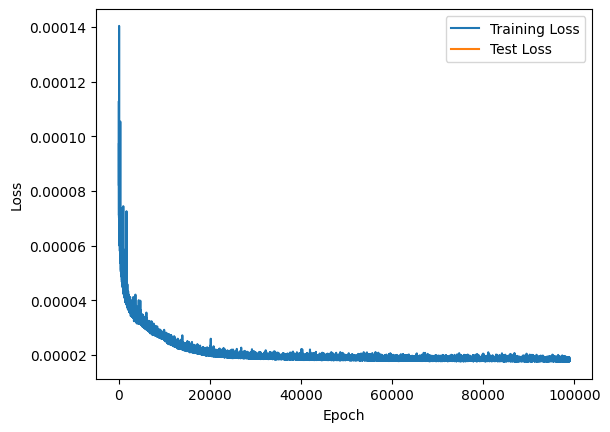

In [32]:
import matplotlib.pyplot as plt

# plot the training and test losses
plt.plot(train_losses[1000:], label='Training Loss')    
plt.plot(test_losses[1000:], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
# move the data back to the CPU
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

# we also neet to move the model back to the CPU
model = model.cpu()

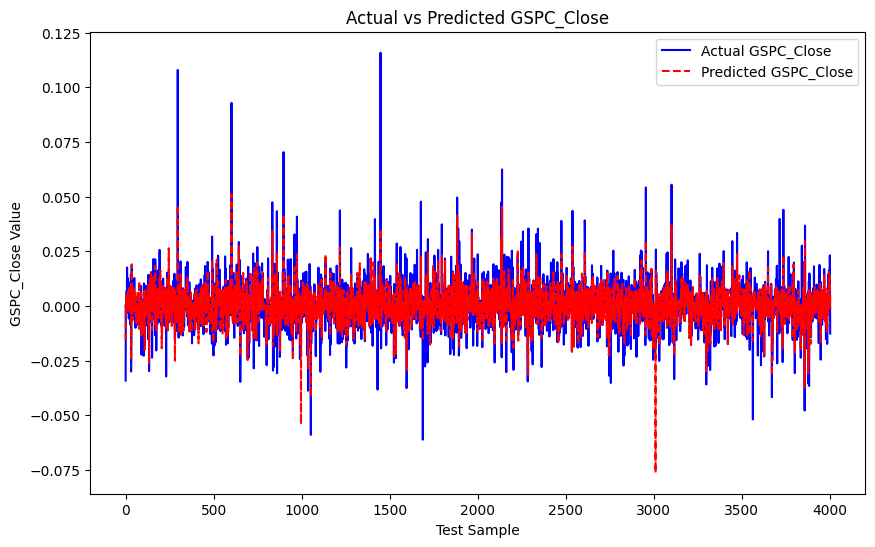

In [34]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode and generate predictions for the test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)

# Convert predictions and actual values to NumPy arrays for plotting
y_test_pred_np = y_test_pred.numpy().flatten()
y_test_actual_np = y_test_tensor.numpy().flatten()

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_np, label='Actual GSPC_Close', color='b')
plt.plot(y_test_pred_np, label='Predicted GSPC_Close', color='r', linestyle='--')
plt.title('Actual vs Predicted GSPC_Close')
plt.xlabel('Test Sample')
plt.ylabel('GSPC_Close Value')
plt.legend()
plt.show()

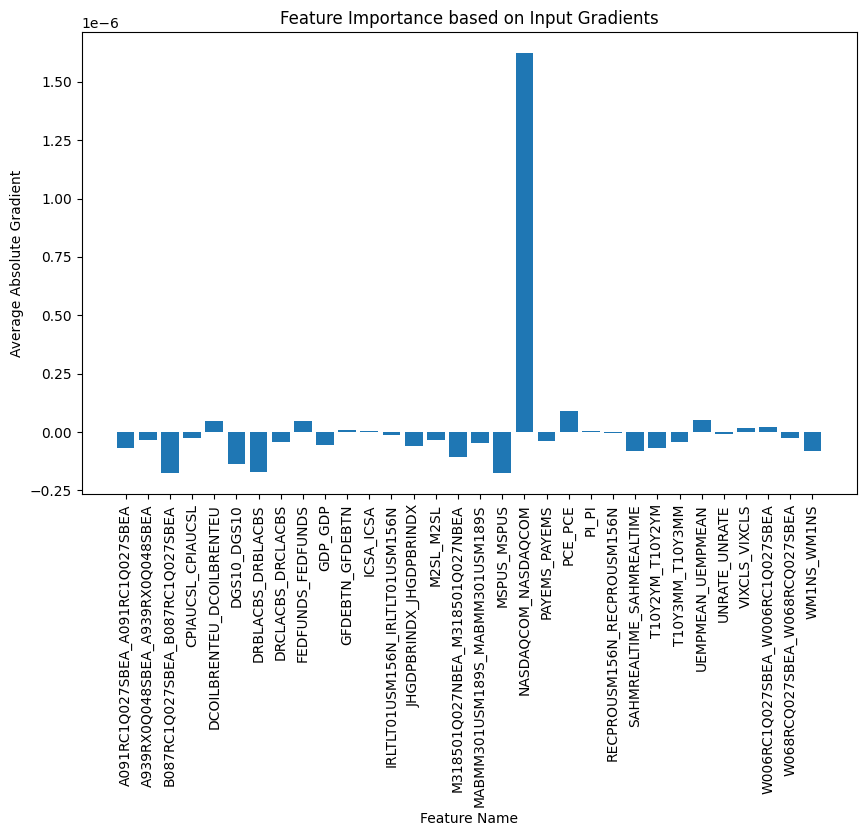

In [35]:
# Set the model in evaluation mode
model.eval()

# Ensure gradients are enabled for the input data
X_test_tensor.requires_grad_(True)

# Forward pass
y_test_pred = model(X_test_tensor)

# Compute gradients (backpropagate with respect to the inputs)
y_test_pred.mean().backward()

# Get the absolute value of gradients for each input feature
input_gradients = X_test_tensor.grad.mean(dim=0).numpy()

# Example: Use feature names in the plot
feature_names = growth_df.columns.drop('GSPC_Close')
plt.figure(figsize=(10, 6))
plt.bar(feature_names, input_gradients)
plt.xticks(rotation=90)
plt.title('Feature Importance based on Input Gradients')
plt.xlabel('Feature Name')
plt.ylabel('Average Absolute Gradient')
plt.show()